## Training Pipeline by [@shonenkov](https://www.kaggle.com/shonenkov) using multi TPU on PyTorch/XLA

Hi everyone!

My name is Alex Shonenkov, I am researcher, in Love with NLP and DL.

Recently I have published my ideas about this competition:

- [[TPU-Inference] Super Fast XLMRoberta](https://www.kaggle.com/shonenkov/tpu-inference-super-fast-xlmroberta)
- [NLP Albumentations](https://www.kaggle.com/shonenkov/nlp-albumentations)
- [Hack with Parallel Corpus](https://www.kaggle.com/shonenkov/hack-with-parallel-corpus)
- [Class Balance with PyTorch/XLA](https://www.kaggle.com/shonenkov/class-balance-with-pytorch-xla)
- [open-subtitles-toxic-pseudo-labeling](https://www.kaggle.com/shonenkov/open-subtitles-toxic-pseudo-labeling)

if you didn't see this kernels and datasets, I recommend to read all of them because it may help you for better understand this kernel and achieve success in competition :)

## MAIN IDEA

I spent a lot of time for create working kernel on the kaggle, I have tried to optimize it for 16GB RAM. But I was not able to do it for distributed MULTI TPU here, because of my datasets is too big for this aims.

Here I would like to demonstrate my training pipeline without running and also I would like to provide you, my firends, prepared Colab notebook with kaggle structure!

So lets start!

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version 20200420 --apt-packages libomp5 libopenblas-dev > /dev/null
!pip install transformers==2.5.1 > /dev/null
!pip install pandarallel > /dev/null
!pip install catalyst==20.4.2 > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3727  100  3727    0     0  49039      0 --:--:-- --:--:-- --:--:-- 49039
Copying gs://tpu-pytorch/wheels/torch-nightly+20200420-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/86.8 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200420-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/117.2 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200420-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/2.4 MiB.                                      
ERROR: fastai 1.0.60 requires torchvision, which is not installed.
ERROR: catalyst 20.3.3 requires torchvision>=0.2.1, which is not installed.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompati

In [2]:
import numpy as np
import pandas as pd

import os
os.environ['XLA_USE_BF16'] = "1"

from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn

import time
import random
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

from transformers import BertModel, BertTokenizer
from transformers import XLMRobertaModel, XLMRobertaTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

import gc
import re

# !pip install nltk > /dev/null
import nltk
nltk.download('punkt')

from nltk import sent_tokenize

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=4, progress_bar=False)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
SEED = 42

MAX_LENGTH = 224
BACKBONE_PATH = 'xlm-roberta-large'
ROOT_PATH = f'..'
# ROOT_PATH = f'/content/drive/My Drive/jigsaw2020-kaggle-public-baseline' # for colab


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

### [NLP Albumentations](https://www.kaggle.com/shonenkov/nlp-albumentations)

In [4]:
from nltk import sent_tokenize
from random import shuffle
import random
import albumentations
from albumentations.core.transforms_interface import DualTransform, BasicTransform


LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

def exclude_duplicate_sentences(text, lang='en'):
    sentences = []
    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()
        if sentence not in sentences:
            sentences.append(sentence)
    return ' '.join(sentences)

def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = exclude_duplicate_sentences(text, lang)
    return text.strip()


class NLPTransform(BasicTransform):
    """ Transform for nlp task."""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

    def get_sentences(self, text, lang='en'):
        return sent_tokenize(text, LANGS.get(lang, 'english'))

class ShuffleSentencesTransform(NLPTransform):
    """ Do shuffle by sentence """
    def __init__(self, always_apply=False, p=0.5):
        super(ShuffleSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = self.get_sentences(text, lang)
        random.shuffle(sentences)
        return ' '.join(sentences), lang

class ExcludeDuplicateSentencesTransform(NLPTransform):
    """ Exclude equal sentences """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeDuplicateSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = []
        for sentence in self.get_sentences(text, lang):
            sentence = sentence.strip()
            if sentence not in sentences:
                sentences.append(sentence)
        return ' '.join(sentences), lang

class ExcludeNumbersTransform(NLPTransform):
    """ exclude any numbers """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeNumbersTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'[0-9]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

class ExcludeHashtagsTransform(NLPTransform):
    """ Exclude any hashtags with # """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeHashtagsTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'#[\S]+\b', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

class ExcludeUsersMentionedTransform(NLPTransform):
    """ Exclude @users """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeUsersMentionedTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'@[\S]+\b', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

class ExcludeUrlsTransform(NLPTransform):
    """ Exclude urls """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeUrlsTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'https?\S+', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

### [Pseudo-labeling with open-subtitles](https://www.kaggle.com/shonenkov/hack-with-parallel-corpus)

More noise with mix of languages can help. I have used [pseudo-labeled open-subtitles dataset](https://www.kaggle.com/shonenkov/open-subtitles-toxic-pseudo-labeling) for this approach. 

It is some analogue for Cutmix in Computer Vision:

<img src='https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2605845%2Ff29492171d83dfa6b6fcae2af414fcf8%2FCutmix_exmaple.png?generation=1579343294489994&alt=media' align="left"> 

In [5]:
class SynthesicOpenSubtitlesTransform(NLPTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(SynthesicOpenSubtitlesTransform, self).__init__(always_apply, p)
        df = pd.read_csv(f'{ROOT_PATH}/input/open-subtitles-toxic-pseudo-labeling/open-subtitles-synthesic.csv', index_col='id')[['comment_text', 'toxic', 'lang']]
        df = df[~df['comment_text'].isna()]
        df['comment_text'] = df.parallel_apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)
        df = df.drop_duplicates(subset='comment_text')
        df['toxic'] = df['toxic'].round().astype(np.int)

        self.synthesic_toxic = df[df['toxic'] == 1].comment_text.values
        self.synthesic_non_toxic = df[df['toxic'] == 0].comment_text.values

        del df
        gc.collect();

    def generate_synthesic_sample(self, text, toxic):
        texts = [text]
        if toxic == 0:
            for i in range(random.randint(1,5)):
                texts.append(random.choice(self.synthesic_non_toxic))
        else:
            for i in range(random.randint(0,2)):
                texts.append(random.choice(self.synthesic_non_toxic))
            
            for i in range(random.randint(1,3)):
                texts.append(random.choice(self.synthesic_toxic))
        random.shuffle(texts)
        return ' '.join(texts)

    def apply(self, data, **params):
        text, toxic = data
        text = self.generate_synthesic_sample(text, toxic)
        return text, toxic

In [6]:
def get_train_transforms():
    return albumentations.Compose([
        ExcludeUsersMentionedTransform(p=0.95),
        ExcludeUrlsTransform(p=0.95),
        ExcludeNumbersTransform(p=0.95),
        ExcludeHashtagsTransform(p=0.95),
        ExcludeDuplicateSentencesTransform(p=0.95),
    ], p=1.0)

def get_synthesic_transforms():
    return SynthesicOpenSubtitlesTransform(p=0.5)


train_transforms = get_train_transforms();
synthesic_transforms = get_synthesic_transforms()
tokenizer = XLMRobertaTokenizer.from_pretrained(BACKBONE_PATH)
shuffle_transforms = ShuffleSentencesTransform(always_apply=True)

In [7]:
def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class DatasetRetriever(Dataset):

    def __init__(self, labels_or_ids, comment_texts, langs, use_train_transforms=False, test=False):
        self.test = test
        self.labels_or_ids = labels_or_ids
        self.comment_texts = comment_texts
        self.langs = langs
        self.use_train_transforms = use_train_transforms
        
    def get_tokens(self, text):
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True, 
            max_length=MAX_LENGTH, 
            pad_to_max_length=True
        )
        return encoded['input_ids'], encoded['attention_mask']

    def __len__(self):
        return self.comment_texts.shape[0]

    def __getitem__(self, idx):
        text = self.comment_texts[idx]
        lang = self.langs[idx]
        if self.test is False:
            label = self.labels_or_ids[idx]
            target = onehot(2, label)

        if self.use_train_transforms:
            text, _ = train_transforms(data=(text, lang))['data']
            tokens, attention_mask = self.get_tokens(str(text))
            token_length = sum(attention_mask)
            if token_length > 0.8*MAX_LENGTH:
                text, _ = shuffle_transforms(data=(text, lang))['data']
            elif token_length < 60:
                text, _ = synthesic_transforms(data=(text, label))['data']
            else:
                tokens, attention_mask = torch.tensor(tokens), torch.tensor(attention_mask)
                return target, tokens, attention_mask

        tokens, attention_mask = self.get_tokens(str(text))
        tokens, attention_mask = torch.tensor(tokens), torch.tensor(attention_mask)

        if self.test is False:
            return target, tokens, attention_mask
        return self.labels_or_ids[idx], tokens, attention_mask

    def get_labels(self):
        return list(np.char.add(self.labels_or_ids.astype(str), self.langs))

### Here I have used [this kernel](https://www.kaggle.com/shonenkov/prepare-training-data) for merging all train data 

In [8]:
%%time

df_train = pd.read_csv(f'{ROOT_PATH}/input/jigsaw-public-baseline-train-data/train_data.csv')


train_dataset = DatasetRetriever(
    labels_or_ids=df_train['toxic'].values, 
    comment_texts=df_train['comment_text'].values, 
    langs=df_train['lang'].values,
    use_train_transforms=True,
)

del df_train
gc.collect();

for targets, tokens, attention_masks in train_dataset:
    break
    
print(targets)
print(tokens.shape)
print(attention_masks.shape)

<string>:2: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



tensor([1., 0.])
torch.Size([224])
torch.Size([224])
CPU times: user 17.9 s, sys: 2.45 s, total: 20.4 s
Wall time: 20.4 s


### Class Balance

After some experiments I have decided that [class balance](https://www.kaggle.com/shonenkov/class-balance-with-pytorch-xla) in this competition is very important. Also I noticed impact if use balancing dataset by languages.

Here you can see unique values for get_labels method:

In [9]:
np.unique(train_dataset.get_labels())

array(['0en', '0es', '0fr', '0it', '0pt', '0ru', '0tr', '1en', '1es',
       '1fr', '1it', '1pt', '1ru', '1tr'], dtype='<U3')

In [10]:
df_val = pd.read_csv(f'{ROOT_PATH}/input/jigsaw-multilingual-toxic-comment-classification/validation.csv', index_col='id')

validation_tune_dataset = DatasetRetriever(
    labels_or_ids=df_val['toxic'].values, 
    comment_texts=df_val['comment_text'].values, 
    langs=df_val['lang'].values,
    use_train_transforms=True,
)

df_val['comment_text'] = df_val.parallel_apply(lambda x: clean_text(x['comment_text'], x['lang']), axis=1)

validation_dataset = DatasetRetriever(
    labels_or_ids=df_val['toxic'].values, 
    comment_texts=df_val['comment_text'].values, 
    langs=df_val['lang'].values,
    use_train_transforms=False,
)

del df_val
gc.collect();

for targets, tokens, attention_masks in validation_dataset:
    break

print(targets)
print(tokens.shape)
print(attention_masks.shape)

tensor([1., 0.])
torch.Size([224])
torch.Size([224])


In [11]:
df_test = pd.read_csv(f'{ROOT_PATH}/input/jigsaw-multilingual-toxic-comment-classification/test.csv', index_col='id')
df_test['comment_text'] = df_test.parallel_apply(lambda x: clean_text(x['content'], x['lang']), axis=1)

test_dataset = DatasetRetriever(
    labels_or_ids=df_test.index.values, 
    comment_texts=df_test['comment_text'].values, 
    langs=df_test['lang'].values,
    use_train_transforms=False,
    test=True
)

del df_test
gc.collect();

for ids, tokens, attention_masks in test_dataset:
    break

print(ids)
print(tokens.shape)
print(attention_masks.shape)

0
torch.Size([224])
torch.Size([224])


In [12]:
class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1)
        y_pred = nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = sklearn.metrics.roc_auc_score(self.y_true, self.y_pred, labels=np.array([0, 1]))
    
    @property
    def avg(self):
        return self.score

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Label Smoothing is all you need
Now we can use translating and augmenting data for training with this Loss: 

In [13]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)
            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
            smooth_loss = -logprobs.mean(dim=-1)
            loss = self.confidence * nll_loss + self.smoothing * smooth_loss
            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

# Custom TPU Fitter

<img src='https://image.made-in-china.com/202f0j10dPkYMNLhhabE/Children-Bicycle-Baby-Kids-BMX-Bike.jpg' width=250 align="left"> 

P.S. Lets go to do contributing [Catalyst](https://github.com/catalyst-team/catalyst) with TPU backend :)

<img src='https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png' width=100 align="center">


In [14]:
import warnings

warnings.filterwarnings("ignore")

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

class TPUFitter:
    
    def __init__(self, model, device, config):
        if not os.path.exists('node_submissions'):
            os.makedirs('node_submissions')

        self.config = config
        self.epoch = 0
        self.log_path = 'log.txt'

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = AdamW(optimizer_grouped_parameters, lr=config.lr*xm.xrt_world_size())
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)

        self.criterion = config.criterion
        xm.master_print(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            para_loader = pl.ParallelLoader(train_loader, [self.device])
            losses, final_scores = self.train_one_epoch(para_loader.per_device_loader(self.device))
            
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            t = time.time()
            para_loader = pl.ParallelLoader(validation_loader, [self.device])
            losses, final_scores = self.validation(para_loader.per_device_loader(self.device))

            self.log(f'[RESULT]: Validation. Epoch: {self.epoch}, loss: {losses.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=final_scores.avg)

            self.epoch += 1
    
    def run_tuning_and_inference(self, test_loader, validation_tune_loader):
        for e in range(2):
            self.optimizer.param_groups[0]['lr'] = self.config.lr*xm.xrt_world_size() / (e + 1)
            para_loader = pl.ParallelLoader(validation_tune_loader, [self.device])
            losses, final_scores = self.train_one_epoch(para_loader.per_device_loader(self.device))
            para_loader = pl.ParallelLoader(test_loader, [self.device])
            self.run_inference(para_loader.per_device_loader(self.device))

    def validation(self, val_loader):
        self.model.eval()
        losses = AverageMeter()
        final_scores = RocAucMeter()

        t = time.time()
        for step, (targets, inputs, attention_masks) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    xm.master_print(
                        f'Valid Step {step}, loss: ' + \
                        f'{losses.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}'
                    )
            with torch.no_grad():
                inputs = inputs.to(self.device, dtype=torch.long) 
                attention_masks = attention_masks.to(self.device, dtype=torch.long) 
                targets = targets.to(self.device, dtype=torch.float) 

                outputs = self.model(inputs, attention_masks)
                loss = self.criterion(outputs, targets)
                
                batch_size = inputs.size(0)

                final_scores.update(targets, outputs)
                losses.update(loss.detach().item(), batch_size)
                
        return losses, final_scores
         
    def train_one_epoch(self, train_loader):
        self.model.train()

        losses = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (targets, inputs, attention_masks) in enumerate(train_loader):   
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    self.log(
                        f'Train Step {step}, loss: ' + \
                        f'{losses.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}'
                    )

            inputs = inputs.to(self.device, dtype=torch.long)
            attention_masks = attention_masks.to(self.device, dtype=torch.long)
            targets = targets.to(self.device, dtype=torch.float)

            self.optimizer.zero_grad()

            outputs = self.model(inputs, attention_masks)
            loss = self.criterion(outputs, targets)

            batch_size = inputs.size(0)
            
            final_scores.update(targets, outputs)
            
            losses.update(loss.detach().item(), batch_size)

            loss.backward()
            xm.optimizer_step(self.optimizer)

            if self.config.step_scheduler:
                self.scheduler.step()
        
        self.model.eval()
        self.save('last-checkpoint.bin')
        return losses, final_scores

    def run_inference(self, test_loader):
        self.model.eval()
        result = {'id': [], 'toxic': []}
        t = time.time()
        for step, (ids, inputs, attention_masks) in enumerate(test_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    xm.master_print(f'Prediction Step {step}, time: {(time.time() - t):.5f}')

            with torch.no_grad():
                inputs = inputs.to(self.device, dtype=torch.long) 
                attention_masks = attention_masks.to(self.device, dtype=torch.long)
                outputs = self.model(inputs, attention_masks)
                toxics = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]

            result['id'].extend(ids.cpu().numpy())
            result['toxic'].extend(toxics)

        result = pd.DataFrame(result)
        node_count = len(glob('node_submissions/*.csv'))
        result.to_csv(f'node_submissions/submission_{node_count}_{datetime.utcnow().microsecond}_{random.random()}.csv', index=False)

    def save(self, path):        
        xm.save(self.model.state_dict(), path)

    def log(self, message):
        if self.config.verbose:
            xm.master_print(message)
        with open(self.log_path, 'a+') as logger:
            xm.master_print(f'{message}', logger)

### Model

In [15]:
from transformers import XLMRobertaModel

class ToxicSimpleNNModel(nn.Module):

    def __init__(self):
        super(ToxicSimpleNNModel, self).__init__()
        self.backbone = XLMRobertaModel.from_pretrained(BACKBONE_PATH)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(
            in_features=self.backbone.pooler.dense.out_features*2,
            out_features=2,
        )

    def forward(self, input_ids, attention_masks):
        bs, seq_length = input_ids.shape
        seq_x, _ = self.backbone(input_ids=input_ids, attention_mask=attention_masks)
        apool = torch.mean(seq_x, 1)
        mpool, _ = torch.max(seq_x, 1)
        x = torch.cat((apool, mpool), 1)
        x = self.dropout(x)
        return self.linear(x)

In [16]:
net = ToxicSimpleNNModel()

# Custom Config

In [17]:
class TrainGlobalConfig:
    num_workers = 0 
    batch_size = 16 
    n_epochs = 3
    lr = 0.5 * 1e-5

    # -------------------
    verbose = True
    verbose_step = 50
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='max',
        factor=0.7,
        patience=0,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

    # -------------------
    criterion = LabelSmoothing()
    # -------------------

### Main method

In [18]:
def _mp_fn(rank, flags):
    device = xm.xla_device()
    net.to(device)

    train_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    validation_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    validation_tune_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_tune_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    validation_tune_loader = torch.utils.data.DataLoader(
        validation_tune_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=validation_tune_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=TrainGlobalConfig.num_workers
    )

    if rank == 0:
        time.sleep(1)
    
    fitter = TPUFitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, validation_loader)
    fitter.run_tuning_and_inference(test_loader, validation_tune_loader)

## Colab Notebook

I hope Kaggle Team will increase RAM memory for tpu notebook as soon as possible. But now I recommend you use colab pro with HIGH RAM mode :)

[Here](https://drive.google.com/drive/folders/1hbcSRfvtTTlERs7remsRST2amIWAFVry?usp=sharing) I have created public read-only google drive with colab notebook! You can save copy and start training right now!

Also you can run this code here with nprocs=1, if you need. It works! But it is very slow (~1.5 P100).

In [19]:
# FLAGS={}
# xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

In [20]:
# submission = pd.concat([pd.read_csv(path) for path in glob('node_submissions/*.csv')]).groupby('id').mean()
# submission['toxic'].hist(bins=100)

Let's imagine that this logs have got using Kaggle:

In [21]:
file = open('../input/jigsaw-public-baseline-results/log.txt', 'r')
for line in file.readlines():
    print(line[:-1])
file.close()


2020-05-04T16:52:20.438990
LR: 4e-05
Train Step 0, loss: 0.00000, final_score: 0.00000, time: 0.82617
Train Step 50, loss: 0.51566, final_score: 0.85479, time: 200.35051
Train Step 100, loss: 0.43166, final_score: 0.92426, time: 251.99104
Train Step 150, loss: 0.39472, final_score: 0.94679, time: 303.32809
Train Step 200, loss: 0.38015, final_score: 0.95423, time: 354.55723
Train Step 250, loss: 0.36591, final_score: 0.96103, time: 405.76366
Train Step 300, loss: 0.36124, final_score: 0.96301, time: 457.29157
Train Step 350, loss: 0.35468, final_score: 0.96579, time: 508.98310
Train Step 400, loss: 0.34817, final_score: 0.96824, time: 560.27298
Train Step 450, loss: 0.34598, final_score: 0.96890, time: 611.92743
Train Step 500, loss: 0.34399, final_score: 0.96969, time: 663.06764
Train Step 550, loss: 0.34247, final_score: 0.97014, time: 714.46248
Train Step 600, loss: 0.34056, final_score: 0.97068, time: 766.03350
Train Step 650, loss: 0.33792, final_score: 0.97173, time: 817.71023
T

This model should be trained ~10 epoch, I have run only 3 epoch for this kernel.

## Submission

If you want to get high score ~0.945-0.946 such as [[TPU-Inference] Super Fast XLMRoberta](https://www.kaggle.com/shonenkov/tpu-inference-super-fast-xlmroberta) you should do blend such as [here](https://www.kaggle.com/hamditarek/ensemble), but I would like to make submission with only this kernel

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c2c79bba8>]],
      dtype=object)

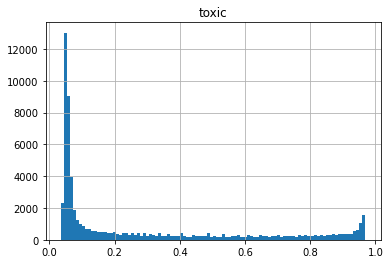

In [22]:
submission = pd.read_csv('../input/jigsaw-public-baseline-results/submission.csv', index_col='id')
submission.hist(bins=100)

In [23]:
submission.to_csv('submission.csv')

### Thank you for reading my kernel!

[Here](https://drive.google.com/drive/folders/1hbcSRfvtTTlERs7remsRST2amIWAFVry?usp=sharing) I have created public read-only google drive with colab notebook! You can save copy and start training right now!


If you like this format of notebooks I would like continue to make kernels with realizations of my ideas.